In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [ ]:
os.chdir("/content/drive/MyDrive/MovieRecommendationSystem")

In [ ]:
dataset = pd.read_csv("dataset/FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("dataset/CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("dataset/CleanedData/ratings_test.csv")

# Content-Based Recommendation System - Pytorch

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

**Make Dataset For Train**

In [ ]:
len_users = ratings_train['userId'].unique().size
print(len_users)

671


There are 671 users 

In [ ]:
len_dataset = len(dataset)
print(len_dataset)

2830


There are 2830 movies rated by users

We need to save the id for later recommendation

In [ ]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,13415,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,6257,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3863,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,7062,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4658,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1621,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1170,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,758,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,1628,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [ ]:
indexToId[0]

949

Standardlize the dataset by each column to mean of 0 and standard deviation of 1

In [ ]:
dataset.drop(columns = ['id'], inplace = True)

In [ ]:
from sklearn import preprocessing

In [ ]:
dataset = preprocessing.scale(dataset)

In [ ]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor

In [ ]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor



In [ ]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [ ]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [ ]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

True

In [ ]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [ ]:
ratings_train


,userId,movieId,rating
0,0,1333,1.0
1,0,618,2.0
2,0,835,2.0
3,0,1614,2.5
4,1,1618,5.0
...,...,...,...
31185,670,861,5.0
31186,670,925,5.0
31187,670,337,4.0
31188,670,1969,4.0


In [ ]:
ratings_test

,userId,movieId,rating
0,0,474,2.5
1,0,522,4.0
2,1,859,3.0
3,1,291,3.0
4,1,217,3.0
...,...,...,...
13794,670,1803,4.0
13795,670,1454,5.0
13796,670,769,4.5
13797,670,1235,3.5


In [ ]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

In [ ]:
ratings_tensor[0][474]

tensor(0., dtype=torch.float64)

All works normally!

Now we will put all those codes into one block

In [ ]:
"""
This codes convert dataset to Tensor data structure
"""

movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [ ]:
from torch.autograd import Variable


In [ ]:
ratings_train_tensor[0][474]

tensor(0., dtype=torch.float64)

# Train
We proposed a Regression Model for predicting Ratings

To predict the rate from user model ***U*** and movies profiles ***M***:

***U * Mᵀ = R̂***

***L = MSE(R̂, R)*** for all movies that have rating

Find the partial derivatives for matrix ***U***: ***$\frac{∂L}{∂U}$***

Update ***U*** based on **$\frac{∂L}{∂U}$**

To calculate derivatives, we use **Autograd** of ***Pytorch***



In [ ]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = ratings_pred.masked_select(mask)
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

In [ ]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use MSELoss (Mean Square Error)

We also use this loss as metrics

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
bestU = None
bestb = None
minLoss = 10e10

First try 3001 loop without regulization, lr = 0.005

In [ ]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')

  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 58.85658848955176. Valid Loss: 60.906788128048085.
Epoch: 10. Train Loss: 52.01296853301646. Valid Loss: 55.653770947764706.
Epoch: 20. Train Loss: 46.1644992730968. Valid Loss: 51.221368908949685.
Epoch: 30. Train Loss: 41.21471605013307. Valid Loss: 47.51578070498739.
Epoch: 40. Train Loss: 37.02758217222618. Valid Loss: 44.40239582051297.
Epoch: 50. Train Loss: 33.465657051585644. Valid Loss: 41.76331552847809.
Epoch: 60. Train Loss: 30.41012597791043. Valid Loss: 39.50301097390818.
Epoch: 70. Train Loss: 27.765836445732884. Valid Loss: 37.54870538131296.
Epoch: 80. Train Loss: 25.45833331854068. Valid Loss: 35.847392394564565.
Epoch: 90. Train Loss: 23.429651508391927. Valid Loss: 34.356864163994906.
Epoch: 100. Train Loss: 21.63430088465397. Valid Loss: 33.04269002092658.
Epoch: 110. Train Loss: 20.03615501349479. Valid Loss: 31.87710048578634.
Epoch: 120. Train Loss: 18.606182796226914. Valid Loss: 30.837544713901607.
Epoch: 130. Train Loss: 17.3207891622057

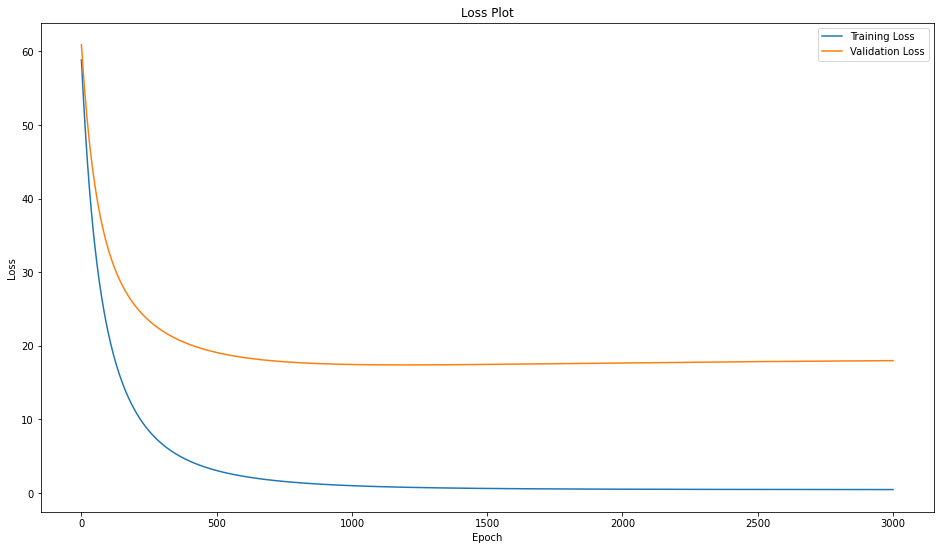

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization weight_decay on ***U*** = 0.05 and ***lr*** = 0.005

In [ ]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.05)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [ ]:
bestU = None
bestb = None
minLoss = 10e10

In [ ]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')

  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 61.186640621157665. Valid Loss: 60.87710660132299.
Epoch: 10. Train Loss: 56.18686979277895. Valid Loss: 56.093711273427594.
Epoch: 20. Train Loss: 51.67450611265618. Valid Loss: 51.7741676906026.
Epoch: 30. Train Loss: 47.645612221845965. Valid Loss: 47.915557267275695.
Epoch: 40. Train Loss: 44.063645780911706. Valid Loss: 44.47848201896665.
Epoch: 50. Train Loss: 40.87310716303723. Valid Loss: 41.40788697927903.
Epoch: 60. Train Loss: 38.015718888877025. Valid Loss: 38.64729262721609.
Epoch: 70. Train Loss: 35.44058322242393. Valid Loss: 36.149056694729815.
Epoch: 80. Train Loss: 33.107773195625576. Valid Loss: 33.875847480719635.
Epoch: 90. Train Loss: 30.98596107933598. Valid Loss: 31.79859152078864.
Epoch: 100. Train Loss: 29.04951078040173. Valid Loss: 29.89442583835398.
Epoch: 110. Train Loss: 27.2765680383457. Valid Loss: 28.143978271808997.
Epoch: 120. Train Loss: 25.648945739941123. Valid Loss: 26.53071739329047.
Epoch: 130. Train Loss: 24.1510658980522

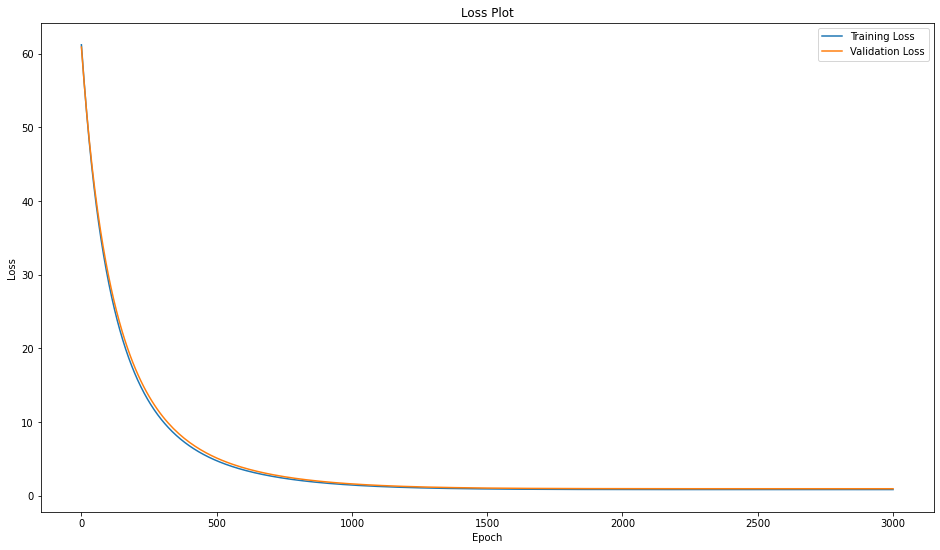

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

In [ ]:
minLoss

tensor(0.9599, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [ ]:
bestU

tensor([[ 8.9951e-05, -1.2868e-03,  6.9160e-05,  ...,  6.1568e-18,
          1.9434e-18,  1.6048e-18],
        [-5.4045e-04, -1.2547e-02,  3.2834e-03,  ...,  3.8808e-03,
          1.0271e-03, -2.3125e-10],
        [ 1.4930e-03, -1.5433e-03, -2.6267e-04,  ...,  2.3211e-03,
         -3.5242e-09, -3.5737e-09],
        ...,
        [ 1.5633e-03,  2.2486e-04,  7.3708e-04,  ...,  4.6119e-03,
         -1.0950e-13, -6.5580e-14],
        [ 3.3820e-03,  1.4995e-03,  1.3651e-03,  ..., -4.7747e-04,
          1.2992e-02, -1.7510e-07],
        [-7.7402e-04,  1.9145e-03, -1.2601e-03,  ...,  6.7063e-03,
         -1.7662e-04,  1.5348e-02]], dtype=torch.float64, requires_grad=True)

In [ ]:
bestU.detach().numpy().tofile("dataset/ModelStorage/U.txt")
bestb.detach().numpy().tofile("dataset/ModelStorage/b.txt")

In [ ]:
with open("dataset/ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("dataset/ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))